In [8]:
import pandas as pd
data = pd.read_csv('../data/BTCUSDT-1m-prep.csv', index_col=0)

In [9]:
data.shape

(2943309, 14)

In [10]:
data.dtypes

open_time           int64
open              float64
high              float64
low               float64
close             float64
volume            float64
num_trades          int64
taker_base_vol    float64
RSI               float64
KAMA              float64
PPO               float64
PVO               float64
ATR               float64
VWAP              float64
dtype: object

In [11]:
data.isnull().sum()

open_time         0
open              0
high              0
low               0
close             0
volume            0
num_trades        0
taker_base_vol    0
RSI               0
KAMA              0
PPO               0
PVO               0
ATR               0
VWAP              0
dtype: int64

In [13]:
data = data.drop(['taker_base_vol', 'num_trades'], axis=1)

In [14]:
data = data.rename(columns={'open_time': 'time'})

In [16]:
# Change UNIX milliseconds to datetime
data['time'] = pd.to_datetime(data['time'], unit='ms')
data.head()

,time,open,high,low,close,volume,RSI,KAMA,PPO,PVO,ATR,VWAP
0,2017-09-01 11:59:00,4775.00,4775.00,4775.00,4775.00,0.070355,0.690908,4775.000000,0.767761,-27.705258,6.283042,4724.424643
1,2017-09-01 12:00:00,4775.00,4775.00,4775.00,4775.00,0.496307,0.690908,4775.000000,0.804877,-20.262442,6.274315,4724.506051
2,2017-09-01 12:01:00,4775.00,4775.00,4775.00,4775.00,0.000000,0.690908,4775.000000,0.835847,-32.342081,6.265601,4724.553523
3,2017-09-01 12:02:00,4779.99,4779.99,4779.99,4779.99,0.534126,0.847622,4775.031760,0.877563,-22.742588,6.263829,4724.649520
4,2017-09-01 12:03:00,4752.94,4752.94,4752.94,4752.94,0.416658,0.000000,4774.907113,0.825946,-18.986390,6.292699,4724.687684


In [17]:
data = data.drop_duplicates()

<Axes: xlabel='volume'>

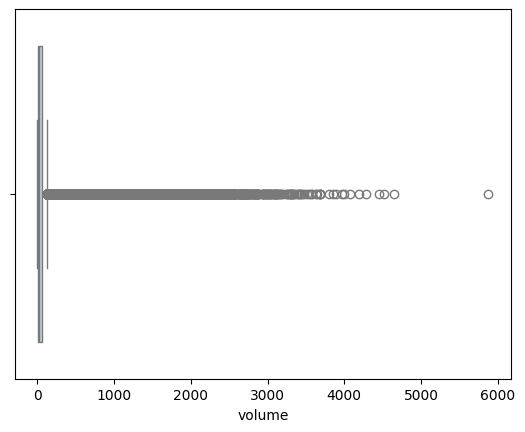

In [20]:
import seaborn as sns
sns.boxplot(x=data['volume'], color='lightblue')

In [26]:
threshold_volume = data['volume'].quantile(0.25)
print(f"Threshold volume: {threshold_volume}")
data_filtered = data[data['volume'] > threshold_volume]
print(f"Filtered data left: {data_filtered.shape[0]}")

Threshold volume: 11.698819
Filtered data left: 2207481


In [27]:
data_filtered.to_csv('../data/BTCUSDT-1m-prep-filtered.csv', index=False)